In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, UpSampling1D, Conv2DTranspose, MaxPool1D, Dropout, Conv1D, Conv2D, Conv3D, Flatten, MaxPool2D, AveragePooling2D, BatchNormalization


In [2]:
im = imread('../data/denoising/lena.png')
noise1 = imread('../data/denoising/lena-noisy.png')
error1 = ((im - noise1)**2).sum()
print ('Noisy image SE: {:.2f}'.format(error1))

Noisy image SE: 338.54


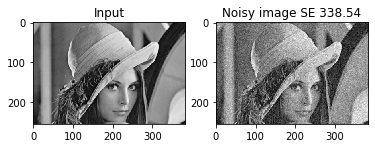

In [3]:
plt.figure(1)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Input')

plt.subplot(122)
plt.imshow(noise1, cmap='gray')
plt.title('Noisy image SE {:.2f}'.format(error1))

plt.show(block=False)

In [4]:
class EncDec1(nn.Module):

    def __init__(self):
        super(EncDec1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3
        self.bn3 = nn.BatchNorm2d(64)
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 1
        self.bn4 = nn.BatchNorm2d(64)
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv5 = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2 
        self.bn5 = nn.BatchNorm2d(32)
        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv6 = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 3
        self.bn6 = nn.BatchNorm2d(16)
        
        self.conv7 = nn.Conv2d(16, 1, 3, 1, 1) # Channe-1
        
    def forward(self, x):
        out = self.bn1(F.relu(self.conv1(x)))
        out = self.bn2(F.relu(self.conv2(out)))
        out = self.bn3(F.relu(self.conv3(out)))
        
        out = self.upsample1(self.bn4(F.relu(self.conv4(out))))
        out = self.upsample2(self.bn5(F.relu(self.conv5(out))))
        out = self.upsample3(self.bn6(F.relu(self.conv6(out))))
        out = F.relu(self.conv7(out))
        return out

In [8]:
MAX_EPOCHS = 5000

net = EncDec1()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.21602942049503326, Error = 21236.55595773304
Loss = 0.06958382576704025, Error = 6840.3682606024195
Loss = 0.04214948043227196, Error = 4143.462535746594
Loss = 0.03061976097524166, Error = 3010.0450693225475
Loss = 0.02430056221783161, Error = 2388.842448300976
Loss = 0.020676419138908386, Error = 2032.5747263403193
Loss = 0.018517792224884033, Error = 1820.3731090855913
Loss = 0.01645059324800968, Error = 1617.1591587834578
Loss = 0.015006624162197113, Error = 1475.2111486012743
Loss = 0.013861505314707756, Error = 1362.6414307530094
Loss = 0.012813298963010311, Error = 1259.5985543983136
Loss = 0.012065702117979527, Error = 1186.1067530911719
Loss = 0.011542610824108124, Error = 1134.6848183666045
Loss = 0.011080252006649971, Error = 1089.233069639796
Loss = 0.01064874418079853, Error = 1046.8141418103346
Loss = 0.010191830806434155, Error = 1001.8977457537336
Loss = 0.009790020063519478, Error = 962.3981306736396
Loss = 0.009382435120642185, Error = 922.3309168367996
Loss 

In [9]:
out = net(eta)
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
error2 = ((im - out_img)**2).sum()

In [10]:
error2

586.328153090367

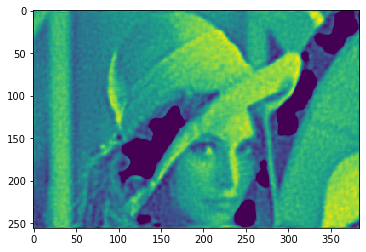

In [11]:
plt.imshow(out_img)